## Vasicek model:

- The model is defined by the following stochastic differential equation (SDE):
     
     $dr(t) =  a(\theta - r(t) dt + \sigma dW(t)$
     
     where $ \theta$  long term mean level., $ a $ is the mean-reversion rate, $ \sigma $ is the volatility, and $ W(t) $ is a Wiener process.

### Simulating the Vasicek processes using Euler–Maruyama method

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def vasicek_EM_simulation(a, sigma, r0, T, dt, theta):
    N = int(T / dt)
    times = np.linspace(0, T, N)
    rates = np.zeros(N)
    rates[0] = r0
    
    for i in range(1, N):
        t = times[i - 1]
        dr = a * (theta - rates[i - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[i] = rates[i - 1] + dr
    
    return times, rates

In [31]:
a = 0.1
sigma = 0.01
theta = 0.02
r0 = 0.05

T = 5.0
dt = 0.01
nb_of_paths = 1000

rates_matrix = np.zeros((nb_of_paths, int(T / dt)))

for i in range(nb_of_paths):
    rates_matrix[i,:] = vasicek_EM_simulation(a, sigma, r0, T, dt, theta)[1]


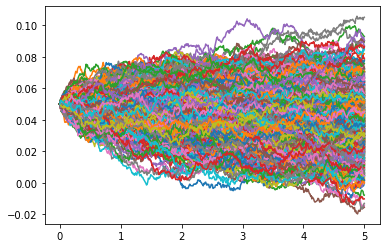

In [32]:
N = int(T/dt)
time = np.linspace(0., int(T), N)

for i in range(nb_of_paths):
    plt.plot(time, rates_matrix[i, :])

### I might estimate $\sigma$ a from historical data through a maximum-likelihood estimator, while finding $\theta$ and $a$ through calibration to market prices

In [36]:
from scipy.stats import norm

def log_likelihood(params, r, dt):
    a, sigma, theta = params
    drift = a * (theta - r[:,:-1]) * dt
    diffusion = sigma * np.sqrt(dt)
    log_likelihood = np.sum(norm.logpdf(r[:,1:], loc=r[:,:-1]+ drift, scale=diffusion))
    return -log_likelihood

In [41]:
from scipy.optimize import minimize

params = [1, 1, 1]
steps = 5
def maximum_loglikelihood_estimator(steps, params, rates_matrix, dt): 
    for i in range(steps):
        result = minimize(log_likelihood, params, args=(rates_matrix, dt), bounds=[(1e-9, None), (1e-9, None), (1e-9, None)], method = 'Nelder-Mead' )
        params = result.x
    return params

a_est, sigma_est, theta_est = maximum_loglikelihood_estimator(steps, params, rates_matrix, dt)

print(f"Estimated parameters a={a_est:.4f}, sigma={sigma_est:.4f}, theta={theta_est:.4f}\n" \
      f"Real parameters a={a:.4f}, sigma={sigma:.4f}, theta={theta:.4f}")

Estimated parameters a=0.0982, sigma=0.0100, theta=0.0210
Real parameters a=0.1000, sigma=0.0100, theta=0.0200


### Line generated from estimated parameters

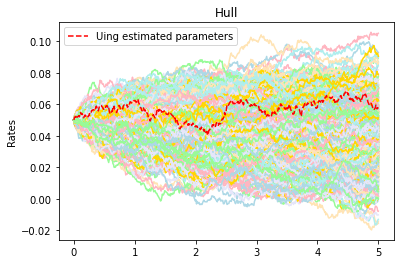

In [44]:
from random import choice
estimated_rates = vasicek_EM_simulation(a_est, sigma_est, r0, T, dt, theta_est)[1]

bright_colors = ['#ADD8E6', '#FFB6C1', '#FFE4B5', '#E6E6FA', '#FFD700', '#98FB98', '#AFEEEE']

for i in range(nb_of_paths):
    plt.plot(time, rates_matrix[i, :], color = choice(bright_colors))
plt.plot(time, estimated_rates, label = 'Using estimated parameters', ls='--', color = 'red')

plt.ylabel('Rates')
plt.title('')

plt.legend(loc = 'upper left')
plt.show()